# Code chunks for Exercise 1

Welcome to this Jupyter notebook collecting many code chunks that are useful for the AF VU exercises. It presents typical Python tools for working with geo data, as also used in professional remote sensing. A focus is put on the first exercise, i.e. classifying forests with optical imagery.

## Some Python libraries you might need

A lot of libraries will be used for the exercise, but don't get intimidated by the amout of imports. They mostly fulfill small tasks. 

First, we import some popular, useful libraries.

In [79]:
import cv2
import datetime
import numpy as np
import pandas as pd
import xarray as xar

Then, we continue with in-house production software for all sorts of data processing. For more information have a look at https://github.com/TUW-GEO.

In [80]:
from geospade.crs import SpatialRef
from veranda.io.geotiff import write_tiff

Several tasks cannot be solely managed with the existing general-purpose packages. Therefore, we have created a helper package dedicated for this lecture.

In [81]:
from afe.dc_add_ons import generate_tree
from afe.dc_add_ons import OpticalDataCube
from afe.geometry import PolygonCollection

Next, we import the `scikit-learn` machine learning framework.

In [82]:
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

Finally, we import `matplotlib` for interactive plots

In [83]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from ipywidgets import widgets, FloatSlider

and activate its `widget` backend. 

In [84]:
%matplotlib widget  
%matplotlib widget 

It is generally a good idea to run these widget-commands twice to avoid issues when changing the backend (https://matplotlib.org/2.0.2/faq/usage_faq.html#what-is-a-backend).

To allow for running the code chunks for any user, we can globally define our username here. Please change the user "cnavacch" to your own username.

In [85]:
USER = "bbauerma"

## `yeoda` datacubes

### Datacube generation

A `yeoda` datacube can be used for managing, filtering and loading bulks of imagery. First, we define the root path of your dataset:

In [8]:
root_dirpath = f"/home/bbauerma/shared/data/sentinel2/L2A"

Next, we create a hierarchical folder tree object 

In [9]:
dir_tree = generate_tree(root_dirpath)

and collect all GeoTIFF files within that repository.

In [10]:
filepaths = dir_tree.file_register

The optical data cube was developed specifically for this exercise for handling multispectral optical image data from Sentinel-2

In [11]:
dc = OpticalDataCube(filepaths=filepaths)

The `inventory` property can be used to view the datacube's content

In [12]:
dc.inventory

,filepath,var_name,time,tile_name
0,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B11,2017-01-01,E051N016T1
1,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B11,2017-01-04,E051N016T1
2,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B11,2017-01-11,E051N016T1
3,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B11,2017-01-14,E051N016T1
4,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B11,2017-01-18,E051N016T1
...,...,...,...,...
30689,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,TCI,2021-12-14,E050N016T1
30690,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,TCI,2021-12-17,E050N016T1
30691,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,TCI,2021-12-21,E050N016T1
30692,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,TCI,2021-12-27,E050N016T1


### Filtering datacubes

First, we select all images between March 1st and April 1st of 2017. The `inplace` key-word specifies, if the current object should be overwritten (`=True`) or not (`=False`). If you set `inplace=True`, you can re-do above command `dc.inventory` and will observe the filter-effect directly.

In [13]:
_ = dc.filter_by_dimension([(datetime.date(2017, 3, 1), datetime.date(2017, 4, 1))], expressions=[('>','<=')], name='time', inplace=True)

Then, we filter by `'var_name'`. "CLOUDMASK" will be thrown out with our choice below. We can check this by looking at the inventory of the datacube.

In [14]:
spectral_bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]
dc.filter_by_dimension(spectral_bands, name="var_name", inplace=True)
dc.inventory

,filepath,var_name,time,tile_name
0,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B02,2017-03-02,E051N016T1
1,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B02,2017-03-05,E051N016T1
2,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B02,2017-03-12,E051N016T1
3,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B02,2017-03-15,E051N016T1
4,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B02,2017-03-25,E051N016T1
...,...,...,...,...
337,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B12,2017-03-02,E050N016T1
338,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B12,2017-03-12,E050N016T1
339,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B12,2017-03-25,E050N016T1
340,/home/bbauerma/shared/data/sentinel2/L2A/EU010...,B12,2017-03-28,E050N016T1


### Loading the datacube's files into memory

The image-files provided in this exercise are delivered as tiles (e.g. "E048N015T1") and contain exactly 10000x10000 data pixels. In the following example, we are interested in data from the tile "E051N016T1" covering Enns.

**ATTENTION**: At the moment, data can only be loaded from one tile. Therefore, one needs to filter the datacube for one tile before trying to load any data.

In [15]:
dc_enns = dc.filter_spatially_by_tilename("E051N016T1")

Note, that there are several functions available for loading data from disk. If you want to load a simple rectangular view of your data `load_available_bands_by_pixels(col, row, col_size, row_size)` does the job perfectly fine. Loading more complex geometries (polygons) is described a bit further below in this notebook. 

What you get here is a data structure called `xarray` (https://xarray.pydata.org), featuring spatial (`x`, `y`) and temporal (`time`) coordinates. For each of these coordinates a set of data variables is defined.

In [16]:
ul_col, ul_row = 5800, 2860
col_size, row_size = 700, 700
loaded_data = dc_enns.load_available_bands_by_pixels(ul_col, ul_row, col_size, row_size)
loaded_data

<xarray.Dataset>
Dimensions:  (time: 7, y: 700, x: 700)
Coordinates:
  * time     (time) object 2017-03-02 2017-03-05 ... 2017-03-29 2017-04-01
  * y        (y) float64 1.642e+06 1.642e+06 1.642e+06 ... 1.635e+06 1.635e+06
  * x        (x) float64 5.129e+06 5.129e+06 5.129e+06 ... 5.136e+06 5.136e+06
Data variables:
    B02      (time, y, x) float64 nan nan nan nan ... 0.0597 0.0577 0.0582
    B03      (time, y, x) float64 nan nan nan nan ... 0.0871 0.0854 0.0878
    B04      (time, y, x) float64 nan nan nan nan ... 0.1101 0.109 0.1073 0.1141
    B05      (time, y, x) float64 nan nan nan nan ... 0.1413 0.1462 0.1462
    B06      (time, y, x) float64 nan nan nan nan ... 0.1712 0.1712 0.177 0.177
    B07      (time, y, x) float64 nan nan nan nan ... 0.1986 0.1947 0.1947
    B08      (time, y, x) float64 nan nan nan nan ... 0.2077 0.2055 0.1996
    B11      (time, y, x) float64 nan nan nan nan ... 0.2734 0.2839 0.2839
    B12      (time, y, x) float64 nan nan nan nan ... 0.2132 0.2217 0.2217

## xarray

### Modifying xarray datasets

There is a myriad of possible things to do with the `xarray` (http://xarray.pydata.org/) library and its data structures.
Let's suppose you have a 2D dataset with two dimensions: One for the day and one for your city. For each day and city, you have one temperature value (e.g., the maximum temperature). Assume, we are now interested in the mean value of temperatures for each city.

In [17]:
cities = ["Munich", "Vienna", "Berlin", "London", "Rome"]
times = pd.date_range("2014-09-06", periods=3)

max_temps = np.random.uniform(low=25, high=38, size=(5, 3))
avg_temps = np.random.uniform(low=20, high=30, size=(5, 3))
min_temps = np.random.uniform(low=15, high=25, size=(5, 3))
humidity = np.random.uniform(low=15, high=100, size=(5, 3))

temp_ds = xar.Dataset(
    coords={
        "city": cities,
        "time": times,
    },
    data_vars={
        "min_temperature": (["city", "time"], min_temps),
        "avg_temperature": (["city", "time"], avg_temps),
        "max_temperature": (["city", "time"], max_temps),
        "humidity": (["city", "time"], humidity)
    }
)
temp_ds

<xarray.Dataset>
Dimensions:          (city: 5, time: 3)
Coordinates:
  * city             (city) <U6 'Munich' 'Vienna' 'Berlin' 'London' 'Rome'
  * time             (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
Data variables:
    min_temperature  (city, time) float64 18.31 20.63 24.42 ... 21.8 24.48 16.27
    avg_temperature  (city, time) float64 26.96 24.39 22.39 ... 28.74 28.43
    max_temperature  (city, time) float64 32.7 29.24 28.95 ... 32.46 36.62 36.23
    humidity         (city, time) float64 63.08 77.43 89.08 ... 60.92 79.82

We define now a new xarray dataset `temps_mean`: `dim` specifies the dimension to apply the mean along. `skipna` is used to signal that NaN (Not-a-Number) values should be ignored. Keep this in mind, you will have to use `skipna` in combination with another function.

In [18]:
temps_mean = temp_ds.mean(dim="time", skipna=False)

### Extracting single data variables from an xarray

The following code shows how to return an `xarray.DataArray` from an `xarray.Dataset`, which will be very useful for extracting single bands of the multispectral data. A detailed description of `DataArray` and `Dataset` data structures can be found here: http://xarray.pydata.org/en/stable/user-guide/data-structures.html

In [19]:
min_temps_extr = temps_mean['min_temperature']
avg_temps_extr = temps_mean['avg_temperature']
max_temps_extr = temps_mean['max_temperature']

avg_temps_extr

<xarray.DataArray 'avg_temperature' (city: 5)>
array([24.58263225, 24.78337381, 22.31950518, 21.73005482, 26.90148584])
Coordinates:
  * city     (city) <U6 'Munich' 'Vienna' 'Berlin' 'London' 'Rome'

### xarray and numpy

xarray extensively uses the popular `numpy` library in its background.

In case you want to extract a `numpy` array from your `xarray` data, which is sometimes needed, you can do that by:
1. (optional) converting your `xarray.Dataset` to `xarray.DataArray` by calling `to_array()` , which removes your data variables but keeps all your data in an n-dimensional array.
2. accessing your `xarray.DataArray`'s `values` property

In [20]:
temps_mean.to_array().values

array([[21.11989602, 16.95874057, 20.10858696, 18.13419497, 20.85340025],
       [24.58263225, 24.78337381, 22.31950518, 21.73005482, 26.90148584],
       [30.29558435, 33.60898056, 31.35590795, 34.23330397, 35.10569341],
       [76.53365949, 73.37972285, 59.64375304, 33.87186037, 61.21139308]])

## RGB composite creation

### Stacking multiple layers

Creating a higher dimensional array from multiple lower dimensional arrays can be done using the `np.stack` function. This will come in handy when creating composite images using several bands of your multispectral image.

In [21]:
stacked_arr = np.stack([min_temps_extr, avg_temps_extr, max_temps_extr], axis=0)
stacked_arr.shape

(3, 5)

### Clip and increase contrast of images

The following functions will be needed for processing your image. For more details on how these functions work and why we need them to increase contrast and correctly encode the data, take a look at https://www.cg.tuwien.ac.at/courses/EinfVisComp/Skriptum/SS13/EVC-11%20Point%20Operations.pdf for a great overview.

In [22]:
def auto_clip(I, percentile=0.02):
    """ 
    Calculates the quantiles of I using the percentile parameter and clips the values using the clip function defined below.
    
    Parameters
    ----------
    I : np.array
        Image array.
    percentile : float, optional
        Percentile defining the clipping boundaries of I in terms of its distribution (defaults to 0.02). 
    
    Returns
    -------
    np.array : 
        Auto-clipped image data.
    
    """
    v_min = np.nanquantile(I, percentile)
    v_max = np.nanquantile(I, 1 - percentile)
    return clip(I, v_min, v_max)

def clip(I, v_min, v_max):
    """ 
    Sets all values in I that are outside of [v_min, v_max] to the corresponding boundary.
    
    Parameters
    ----------
    I : np.array
        Image array.
    v_min : number
        Lower clipping boundary.
    v_max : number
        Upper clipping boundary.
    
    Returns
    -------
    np.array : 
        Clipped image data.
        
    """
    I[I < v_min] = v_min
    I[I > v_max] = v_max
    return I

def normalize(I, p_min, p_max):
    """
    Linearly interpolates/maps all values of I to the range [p_min, p_max]. 
    For example, you could normalize your image to 0 - 255 for viewing. 
    
    Parameters
    ----------
    I : np.array
        Image array.
    p_min : number
        Lower normalisation boundary of the output range.
    p_max : number
        Upper normalisation boundary of the output range.
    
    Returns
    -------
    np.array : 
        Normalised image data within the range [p_min, p_max].
    
    """
    q_min = np.nanmin(I)
    q_max = np.nanmax(I)
    return (p_max - p_min) * (I - q_min) / (q_max - q_min) + p_min

To create an RGB composite we can select a single date from our datacube-subset

In [23]:
single_image = loaded_data.sel(time=datetime.date(2017, 4, 1))

extract the corresponding bands

In [24]:
b02 = single_image['B02'].values
b03 = single_image['B03'].values
b04 = single_image['B04'].values

and stack them.

In [25]:
rgb_raw = np.stack([b04, b03, b02], axis=2)

Enhancing its contrast can for instance be achieved by applying the `auto_clip` function to remove extreme values. It is important to pass a copy as argument to `auto_clip`, because the argument array will be overwritten.

In [26]:
rgb_clipped = auto_clip(rgb_raw.copy(), percentile=0.02)

Applying a non-linear function such as `log` to your image may also enhance the contrast.

In [27]:
rgb_raw_log = np.log(rgb_raw)

### Histogram

The `hist()` function used below only accepts one dimensional arrays. The dimension of an array can be reduced using the `flatten()` function.

In [28]:
flat_b02 = rgb_clipped[:, :, 2].flatten()
flat_b03 = rgb_clipped[:, :, 1].flatten()
flat_b04 = rgb_clipped[:, :, 0].flatten()

Use `matplotlib.pyplot` to create figure and axis objects. Now we can plot a histogram of band 2, band 3, and band 4 consisting of 300 bins. `alpha` can be used to control transparency.

Text(0, 0.5, 'n')

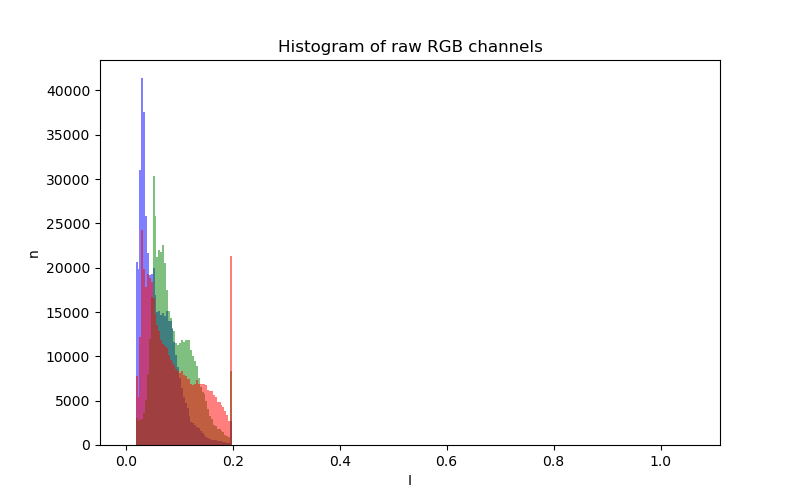

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))

mbins = np.linspace(np.nanmin(rgb_raw), np.nanmax(rgb_raw), 300)
ax.hist(flat_b02, color='blue', bins=mbins, alpha=0.5)
ax.hist(flat_b03, color='green', bins=mbins, alpha=0.5)
ax.hist(flat_b04, color='red', bins=mbins, alpha=0.5)

ax.set_title('Histogram of raw RGB channels')
ax.set_xlabel('I')
ax.set_ylabel('n')

Text(0, 0.5, 'n')

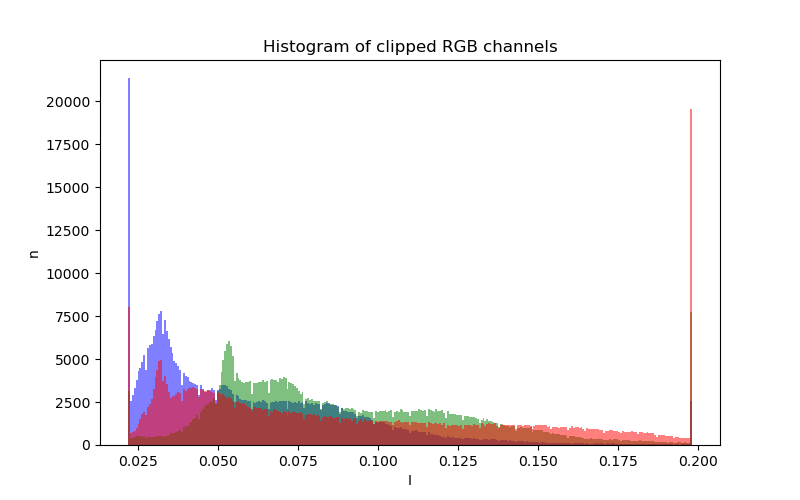

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

mbins = np.linspace(np.nanmin(rgb_clipped), np.nanmax(rgb_clipped), 300)
ax.hist(flat_b02, color='blue', bins=mbins,  alpha=0.5)
ax.hist(flat_b03, color='green', bins=mbins,  alpha=0.5)
ax.hist(flat_b04, color='red', bins=mbins, alpha=0.5)

ax.set_title('Histogram of clipped RGB channels')
ax.set_xlabel('I')
ax.set_ylabel('n')

### Image Plot

Note, that `imshow()` accepts both 2D data as wells as 3D data with 3 channels (m,n,3) and can therefore also be used for RGB images.

Text(0.5, 1.0, 'RGB composit (raw)')

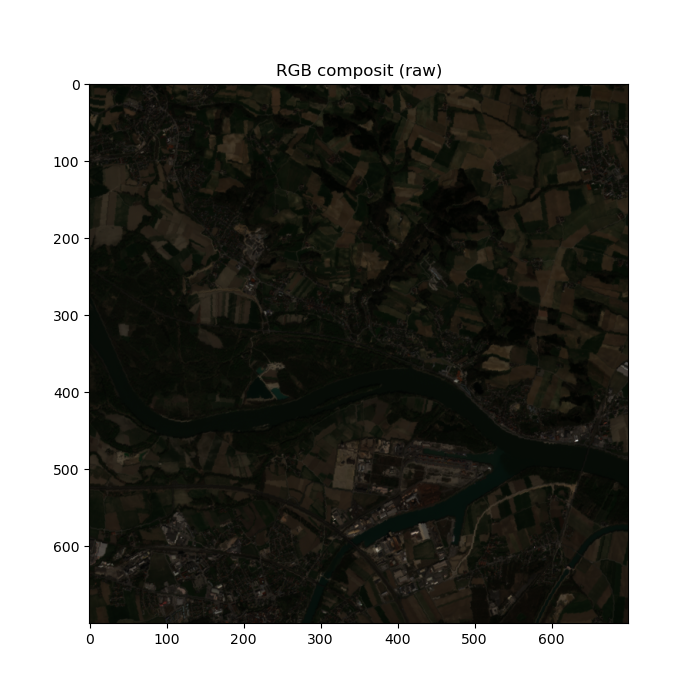

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))

# plot the image
rgb_stretched = normalize(rgb_raw, 0, 1)
raw_img = ax.imshow(rgb_stretched)

# set a title
ax.set_title('RGB composit (raw)')

Text(0.5, 1.0, 'RGB composit (clipped)')

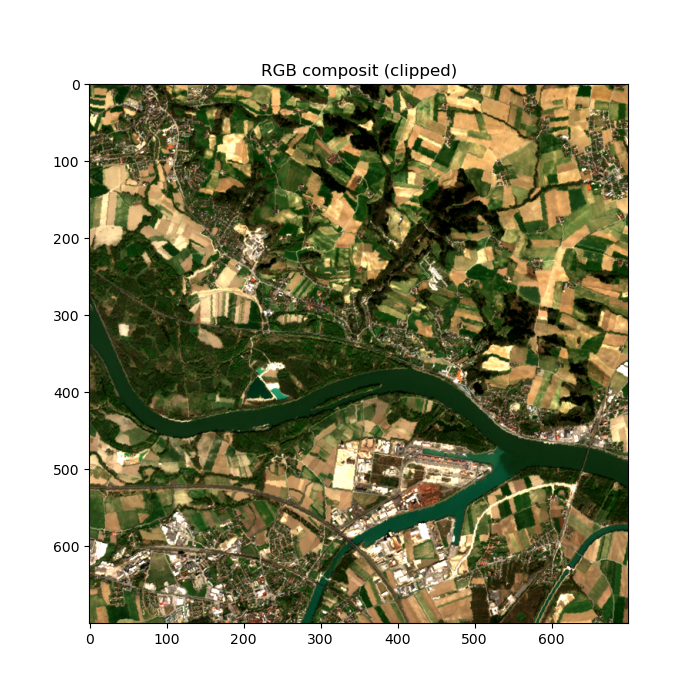

In [78]:
fig, ax = plt.subplots(figsize=(7, 7))

# plot the image
rgb_stretched = normalize(rgb_clipped,0,1)
b02_img = ax.imshow(rgb_stretched)

# set a title
ax.set_title('RGB composit (clipped)')

## Training and classification

This section presents how one can perform some simple remote sensing image classification techniques. As a use case, we have created a small training dataset containing polygons, which cover forest and non-forest pixels. In the following we will show how one can read Sentinel-2 data intersecting with these polygons and how to prepare the loaded data as input to a classifier.

### Read ROI polygons from GeoJSON files

The polygons have been drawn with QGIS and were exported to a GeoJSON file (see lecture materials how this is done), one for each class (forest/non-forest). All polygons are located within the tile "E048N015T1", which covers some parts of Tyrol.

**ATTENTION**: Ensure that you have drawn the polygons in the right spatial reference system, i.e. the spatial reference system of the Sentinel-2 data, the Equi7Grid system (see documentation here: https://github.com/TUW-GEO/Equi7Grid/blob/master/docs/doc_files/EQUI7_V14_grid_and_tiling_definition_document_issue07.pdf). You can also check out the "ue1_code_chunks_appendix" Jupyter notebook containing information how to reproject polygons to the correct spatial reference system.

In [33]:
forest_polygons_path = f"/home/bbauerma/shared/afe22w/notebooks/ue1/forestr.geojson"

We can create a `PolygonCollection` object from this file.

In [34]:
forest_polygons = PolygonCollection.from_geojson_file(forest_polygons_path)

The next statement returns an `ogr.Geometry` object to work with.

In [35]:
forest_geom = forest_polygons.ogr_multipolygon

For the next steps, we can also generate a dictionary mapping polygon IDs to `ogr.Geometry` representations of the polygons. Make sure, you do not have duplicate polygon IDs in your dataset otherwise some data will get lost in this step.

In [36]:
forest_polygon_dict = forest_polygons.polygon_dictionary

### Clean up data

It might occur that you have empty polygon objects in your dataset. This can happen through accidental clicks when drawing in QGIS. No worries! They can be easily removed.

In [37]:
def remove_empty_polygons(poly_dict):
    """ 
    Removes all entries (ids and values) from your polygon dictionary where the `ogr.Geometry` object is empty. 
    
    Parameters
    ----------
    poly_dict : dict
        Dictionary containing a map between polygon IDs and `ogr.Geometry` polygons.
    
    Notes
    -----
    Modifies object in place.
    
    """
    polygons_to_remove = []
    for poly_id, poly in poly_dict.items():
        if poly.IsEmpty():
            polygons_to_remove.append(poly_id)

    for key in polygons_to_remove:
        del poly_dict[key]
        
remove_empty_polygons(forest_polygon_dict)

### Load polygon data from datacube

First, we filter the data cube for data from the tile "E048N015T1" and from only one day to fit in memory.

In [38]:
dc_tyrol = dc.filter_spatially_by_tilename("E048N015T1")
dc_tyrol = dc_tyrol.filter_by_dimension(datetime.date(2017, 3, 28), name="time")

Secondly, we pick an arbitrary polygon from the dictionary (for demonstrative purposes).

In [39]:
some_polygon_id = list(forest_polygon_dict)[0]
some_polygon = forest_polygon_dict[some_polygon_id]

By passing an `ogr.Geometry` object and setting `apply_mask` to `True` (default value) certain pixels can be selected to be loaded into memory. Values outside of the polygon areas are set to NaN (`np.nan`). The `xarray` returned has the geometry's bounding box as the spatial extent. Make sure the geometry object is projected in the right way!

In [40]:
some_polygon_data = dc_tyrol.load_available_bands_by_geom(some_polygon, apply_mask=True)

/home/bbauerma/.conda/envs/afe22w/lib/python3.7/site-packages/geospade/crs.py:527: UserWarning: Conversion from 'PROJ4' to 'EPSG' is not possible.
  warnings.warn(warn_msg.format(self._sref_type.upper(), tar_sref_type.upper()))


Repeating the step shown above using a dictionary comprehension allows to create a map from polygon ID to the corresponding `xarray` object.

In [41]:
forest_data_dict = {poly_id: dc_tyrol.load_available_bands_by_geom(poly, apply_mask=True) for poly_id, poly in forest_polygon_dict.items()}

This object can be used to calculate the mean value of each data variable (band) over time and return a new dictionary. There might be another function available that could help you to remove cloudy pixels.

In [42]:
mean_forest_data_dict = {poly_id: poly_xar.mean(dim='time', skipna=True) for poly_id, poly_xar in forest_data_dict.items()}

### Prepare input (X) and output (y) variable for training classifiers

The input data will consist of rows of nine values, where each row represents a pixel and each column represents a band.

In [43]:
num_of_bands = 9

First, we reshape the forest polygon data to get a tuple (one value per band) of pixel values. Information about the spatial location of the pixel is not relevant for training the classifier and is therefore lost. By using `np.concatenate` the rows of the different polygons are concatenated to a single array for further processing

In [44]:
X_forest_data = np.concatenate([poly_xar.to_array().values.reshape(num_of_bands, -1).T for _, poly_xar in mean_forest_data_dict.items()])
X_forest_data.shape

(406536, 9)

Only not-NaN values can be used for training, therefore we need to remove everything else. An array with rows not containing any NaN values can be generated using the expression below. Note, that a single missing value removes an entire row!

In [45]:
X_forest_data = X_forest_data[~np.isnan(X_forest_data).any(axis=1)]
X_forest_data.shape

(185025, 9)

Assuming that you want to represent the result "this pixel is a forest pixel" as 1, the output vector can be created as follows.

In [46]:
y_forest_data = np.ones(X_forest_data.shape[0])

Since you need pixels of all classes for training, the final matrix (input variable, X) and vector (output variable, y) can be put together using the following function.

In [47]:
X_A = [[1, 2, 3], [4, 5, 6], [2, 3, 1], [4, 4, 4]]
X_B = [[7, 8, 9], [10, 11, 12], [12, 7, 8], [14, 8, 9]]
X = np.concatenate([X_A, X_B])
X

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 2,  3,  1],
       [ 4,  4,  4],
       [ 7,  8,  9],
       [10, 11, 12],
       [12,  7,  8],
       [14,  8,  9]])

In [48]:
y_A = [1, 1, 1, 1]
y_B = [0, 0, 0, 0]
y = np.concatenate([y_A, y_B])
y

array([1, 1, 1, 1, 0, 0, 0, 0])

### Split data into training and testing sets

Your task is to both train and test the classifier. To do this, your pixel values - including the ground truth - will be separated into a set used only for training and a set used only for testing. `scikit-learn` provides a very convenient method for doing exactly that: `train_test_split` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

The following example shows how to randomly split your data, where roughly 75% are used for training and the remaining 25% will be used for testing purposes. You can pass an integer (seed state) using random_state to ensure reproducibility.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Creating, training and using classifiers

`scikit-learn` provides a wide variety of classifiers. Here's an example using a decision tree for classification.

In [50]:
tree_clf = tree.DecisionTreeClassifier()

Train your classifier object. Be aware that, depending on the classifier and the size of your training data, this process might take a while.

In [51]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

Use the trained object to make predictions. `fit` must always be called before `predict`!

In [52]:
tree_clf.predict(X_test)

array([1, 0])

### Print classification report

`scikit-learn` provides a function to automatically generate classification reports. The first argument to pass is the ground truth, the second argument are the predictions.

In [53]:
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



Alternatively, a simple confusion matrix can also be generated.

In [54]:
confusion_matrix(y_test, tree_clf.predict(X_test))

array([[1, 0],
       [0, 1]])

### Testing your skills

It is advised to play around with the `scikit-learn` library to get a feeling for how the training and prediction works in Python. `scikit-learn` provides nice datasets for exactly this purpose. The following dataset for example can be imported easily into your Jupyter notebook and is nicely suitable for testing classification algorithms.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

### Applying a classifier to an image

When applying a classifier to an image, you first have to reshape your image data to a format which the classifier is able to handle.
In the case of a Sentinel-2 optical image, this matrix should ideally have a shape of $(\text{number of pixels}, \text{number of bands})$. To do so, we extract a `numpy` array from the xarray image and retrieve its shape.

In [55]:
np_bands = single_image.to_array().values
num_of_bands, nr, nc = np_bands.shape

`predict` expects the band/feature axis along the last axis (also `imshow`) and a shape as described before.

In [56]:
np_bands = np.moveaxis(np_bands, 0, -1)
X_im = np_bands.reshape(-1, num_of_bands)

In case there are NaN values in the array to predict and the classifier does not support NaN-safe predicition, one can replace them with a default value and set them to NaN after the prediction again.

In [57]:
X_nan_mask = np.isnan(X_im)
X_im[X_nan_mask] = 0
y_nan_mask = np.any(X_nan_mask, axis=-1).reshape((nr * nc, 1))
# y_im = classifier.predict(X_im)
# random numbers as a mock-up example
y_im = np.random.random((nr * nc, 1))
y_im[y_nan_mask] = np.nan

Finally, the resulting prediction of shape $(\text{number of pixels}, 1)$ then has to be reshaped to the original shape of the image.

In [58]:
y_im = y_im.reshape((nr, nc))

## Exporting images as GeoTIFF files

Loading everything from a datacube, i.e. using the full Equi7Grid tile extent, is commonly not possible due to memory limitations. Therefore, one often selects a spatial subset as you have seen before when using the function `load_available_bands_by_pixels`. However, as soon as you have loaded data, any geographical/spatial context with respect to the original tile is lost. `geospade` can help you to keep track of this and to easily propagate the geospatial context until writing your processed data to disk.

First, we can extract a `RasterGeometry` object from an existing datacube. Note that this requires the datacube to only contain data from one Equi7 grid tile!

In [59]:
raster_geom = dc_enns.raster_geometry

This object basically manages all geometric operations and properties of a raster file. More details can be found under: https://geospade.readthedocs.io/en/latest/notebooks/raster_geometry.html. So in addition to loading as before

In [60]:
loaded_data = dc_enns.load_available_bands_by_pixels(ul_col, ul_row, col_size, row_size)
loaded_data

<xarray.Dataset>
Dimensions:  (time: 7, y: 700, x: 700)
Coordinates:
  * time     (time) object 2017-03-02 2017-03-05 ... 2017-03-29 2017-04-01
  * y        (y) float64 1.642e+06 1.642e+06 1.642e+06 ... 1.635e+06 1.635e+06
  * x        (x) float64 5.129e+06 5.129e+06 5.129e+06 ... 5.136e+06 5.136e+06
Data variables:
    B02      (time, y, x) float64 nan nan nan nan ... 0.0597 0.0577 0.0582
    B03      (time, y, x) float64 nan nan nan nan ... 0.0871 0.0854 0.0878
    B04      (time, y, x) float64 nan nan nan nan ... 0.1101 0.109 0.1073 0.1141
    B05      (time, y, x) float64 nan nan nan nan ... 0.1413 0.1462 0.1462
    B06      (time, y, x) float64 nan nan nan nan ... 0.1712 0.1712 0.177 0.177
    B07      (time, y, x) float64 nan nan nan nan ... 0.1986 0.1947 0.1947
    B08      (time, y, x) float64 nan nan nan nan ... 0.2077 0.2055 0.1996
    B11      (time, y, x) float64 nan nan nan nan ... 0.2734 0.2839 0.2839
    B12      (time, y, x) float64 nan nan nan nan ... 0.2132 0.2217 0.2217

we can intersect the `RasterGeometry` object in a similar way.

In [61]:
loaded_data_geom = raster_geom.slice_by_rc(ul_col, ul_row, col_size, row_size)

Now, with the data subset and its geospatial context at hand, we can write some data layers to disk. After defining the destiny file path

In [62]:
dst_filepath = f'/home/bbauerma/my_new_file.tiff'

and the metadata information for the GeoTIFF header, i.e. six geotransformation parameters and spatial reference system information given as a WKT string,

In [63]:
write_tags = {'geotransform': loaded_data_geom.geotrans,
              'spatialreference': loaded_data_geom.sref.wkt}

we can export 2D (grayscale) data by using the `src_arr` argument of `write_tiff`. The data for each band is 3D (time, y, x), e.g. (1, 1000, 1000) for the example above, but we only need a 2D `numpy` array to be written to disk. To do so, we can use `[0, :, :]`, or in short `[0, ...]`, to select the first image layer.

In [64]:
src_arr = loaded_data['B11'].values[0, ...]
write_tiff(dst_filepath, src_arr=src_arr, tags_dict=write_tags)

or the key-words `red`, `green`, and `blue` for multichannel (RGB) images.

In [65]:
dst_rgb_filepath = f'/home/bbauerma/my_new_rgb_file.tiff'
write_tiff(dst_rgb_filepath, red=rgb_stretched[:, :, 0], green=rgb_stretched[:, :, 1], blue=rgb_stretched[:, :, 2], tags_dict=write_tags)

## Calculating NDVI

NDVI and many other indices rely on the normalized difference, represented by the function below

In [66]:
def normalized_difference(a, b):
    return (a - b) / (a + b)

def ndvi(xar_data):
    return normalized_difference(xar_data['<band A>'], xar_data['<band B>'])

The `ndvi` function takes an `xarray.Dataset` where both `'<band A>'` and `'<band B>'` are data variables and returns an `xarray.DataArray` for the resulting NDVI. Note, that `'<band A>'` and `'<band B>'` are only placeholders. Think about which bands have to be used for computing the NDVI.

## Creating logical matrices

Generate random 100x100 matrix filled with values from 0 to 1.

In [67]:
rand_mat = np.random.rand(100, 100)

Create a logical matrix with the same dimensions as `rand_mat`, where values greater than 0.7 are assigned `True`, the rest is `False`:

In [68]:
log_mat = (rand_mat > 0.7)
log_mat

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True, False,  True]])

Such a logical matrix can then be applied to mask values in a fashionable manner.

In [69]:
42 * True

42

In [70]:
123 * False

0

In [71]:
np.array([[1, 2], [3, 4]]) * np.array([[True, False], [False, True]])

array([[1, 0],
       [0, 4]])

In [72]:
rand_mat * log_mat

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.96446576, ..., 0.        , 0.76804215,
        0.83472728],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.825486  , 0.79299376, 0.82528694, ..., 0.        , 0.        ,
        0.76241834],
       [0.        , 0.        , 0.93753921, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.84718322, 0.        ,
        0.83805115]])

## Building a custom classifier

Shown below is the class structure for building a classifier. Just like the `scikit-learn` counterparts, it can be used by calling a `fit(X, y)` and a `predict(X)` function.

In [73]:
class MyGNBClassifier:
    
    def __init__(self):
        self.fitted = False
        pass
    
    def fit(self, X, y):
        """ 
        This function takes an input variable X and an output variable y to calculate a threshold for classification.
        For simplicity, you have to only program this classifier for one dimensional input data X, where a single, scalar threshold value is sufficient for classification.
        """
        # here comes your code for fitting the classifier (i.e. calculating the threshold)
        # tip: things are less messy when defining and using functions for certain tasks (calculating priors etc.)
        self.fitted = True
    
    def calculate_priors(self, y):
        pass
    
    def calculate_means(self, X, y):
        pass
    
    def calculate_variance(self, X, y):
        pass
    
    def calculate_threshold(self):
        pass
    
    def predict(self, X):
        if not self.fitted:
            raise Exception('The classifier has not yet been fitted. Please use the fit(X, y) function to do so.')
        # here comes your code for generating a prediction

### Comparison of the threshold predicted with Gaussian Naive Bayes to a custom threshold

The function shown below accepts two parameters. 
- First, a 2D grayscale `xarray.DataArray` containing - for example - your NDVI values.
- Second, a logical mask created by your GNB implementation.

_What does the function do?_

With the two variables passed, the function generates an interactive plot containing two subplots. The subplot on the right is simply a visual representation of the NDVI data with the logical mask from the forest prediction overlayed in green. The subplot on the left is also a visual representation of the NDVI data, but now, the mask is generated by the threshold specified via the slider below the plot.

_Why do I need the function?_

The function allows an interactive way of exploring how the GNB classifier works. Plotting a histogram of your NDVI values for each class is extremely helpful for this. The function can be used as is, but feel free to change things (colors, labels etc.) that might feel better for you.

In [86]:
def plot_classification(ndvi_data, forest_prediction):
    ndvi_data = ndvi_data.squeeze().values
    
    # generate a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    
    fig.tight_layout()
    
    ax1.set_title('custom threshold')
    ax2.set_title('classification using gaussian naive bayes')
    
    binary_forest_map = colors.ListedColormap(['black', 'limegreen'])
    
    ax2.imshow(ndvi_data, cmap='BuPu')
    ax2.imshow(np.ma.masked_where(forest_prediction < 1, forest_prediction), cmap=binary_forest_map, clim=[0, 1])
    
    # define a function to update the plot
    def update(threshold):
        ax1.cla()
        ax1.set_title('custom threshold')
        ndvi_threshold_logical = np.where(ndvi_data > threshold, 1, 0)
        ax1.imshow(ndvi_data, cmap='BuPu')
        ax1.imshow(np.ma.masked_where(ndvi_threshold_logical < 1, ndvi_threshold_logical), cmap=binary_forest_map, clim=[0, 1])
    
    
    # setup the slider objects
    threshold = FloatSlider(min=np.nanmin(ndvi_data), max=np.nanmax(ndvi_data), value=0.07, description='Threshold', step=0.02)
    
    # arrange the sliders in a box
    ui = widgets.HBox([threshold])

    # generate the widget
    out = widgets.interactive_output(update, {'threshold': threshold})
    
    return display(out, ui)

Here's an hands-on example of the function. But instead of NDVI data, the band 'B03' is used here. 
So, the data is simply an `xarray.DataArray` with 'B03' data and the mask is a logical array with an (arbitrary) threshold of 0.3.

Output()

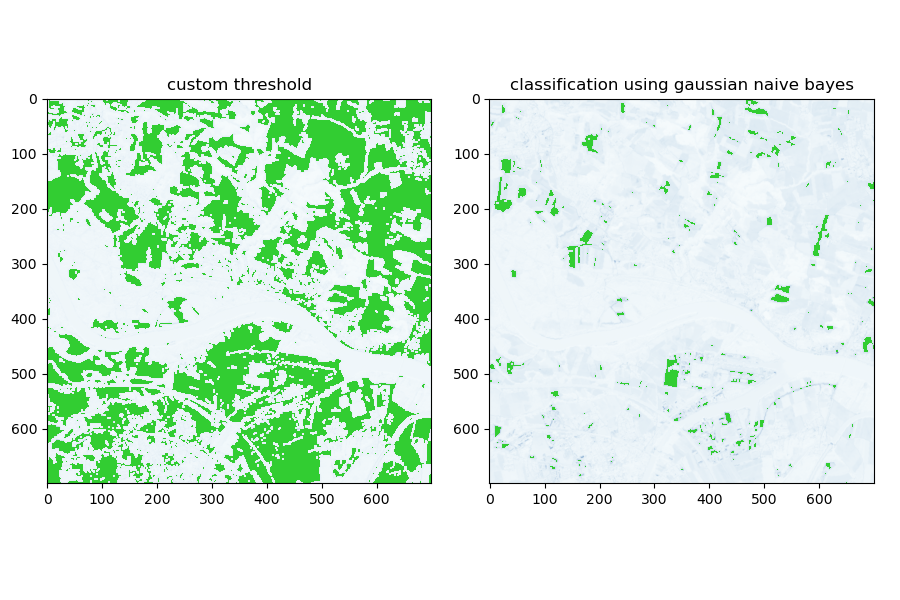

In [88]:
classification_plot = plot_classification(single_image['B03'], (single_image['B03'] > 0.15))